In [2]:
import pandas as pd
import openpyxl
import statsmodels.api as sm
import matplotlib.pylab as plt
%matplotlib inline

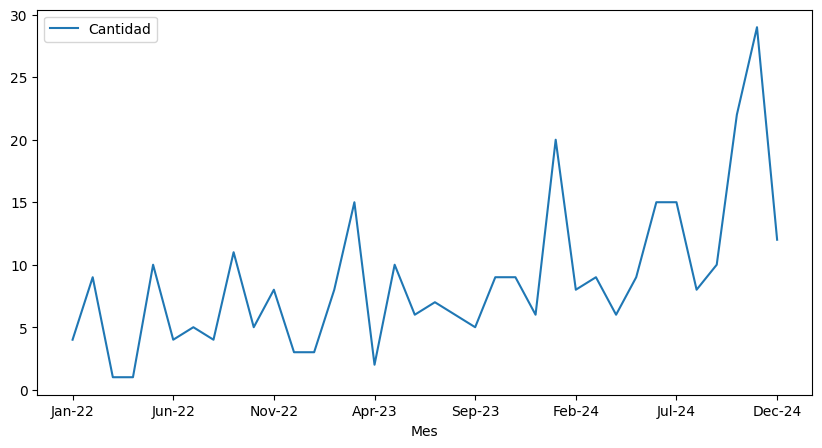

        Cantidad
Mes             
Jan-22         4
Feb-22         9
Mar-22         1
Apr-22         1
May-22        10
Jun-22         4
Jul-22         5
Aug-22         4
Sep-22        11
Oct-22         5
Nov-22         8
Dec-22         3
Jan-23         3
Feb-23         8
Mar-23        15
Apr-23         2
May-23        10
Jun-23         6
Jul-23         7
Aug-23         6
Sep-23         5
Oct-23         9
Nov-23         9
Dec-23         6
Jan-24        20
Feb-24         8
Mar-24         9
Apr-24         6
May-24         9
Jun-24        15
Jul-24        15
Aug-24         8
Sep-24        10
Oct-24        22
Nov-24        29
Dec-24        12


In [237]:
base_ventas = pd.read_excel(r"/home/serway_85/ventasParasoles (2) (2).xlsm",sheet_name='ventas',index_col='Mes')
#base_ventas['Mes']=base_ventas['Mes'].dt.strftime('%b-%y')
base_ventas_pergotek=base_ventas[(base_ventas['Familia']=='PERGOTEK') & (base_ventas['Tipo Factu']== 'PRODUCTO TERMINADO')]
total_nulos=base_ventas_pergotek.isnull().sum()
total_nulos

base_ventas

base_ventas.reset_index(inplace=True)
base_ventas['Mes'] = pd.to_datetime(base_ventas['Mes'], errors='coerce')

base_ventas.reset_index(inplace=True)
#base_ventas['Mes'] = pd.to_datetime(base_ventas['Mes'], errors='coerce')
#base_ventas['Mes'] = base_ventas['Mes'].dt.strftime('%b-%y')
base_ventas.set_index('Mes', inplace=True)
base_analisis=base_ventas[base_ventas['Familia']=='PERGOLITE']

base_analisis=base_analisis.groupby(['Mes'])['Cantidad'].sum().reset_index()
base_analisis = base_analisis.sort_values('Mes')
base_analisis['Mes'] = base_analisis['Mes'].dt.strftime('%b-%y')
base_analisis.set_index('Mes',inplace=True)



ventas=base_analisis['Cantidad']
base_analisis.plot(y='Cantidad',kind='line',figsize=(10,5))
plt.show()
print(base_analisis)



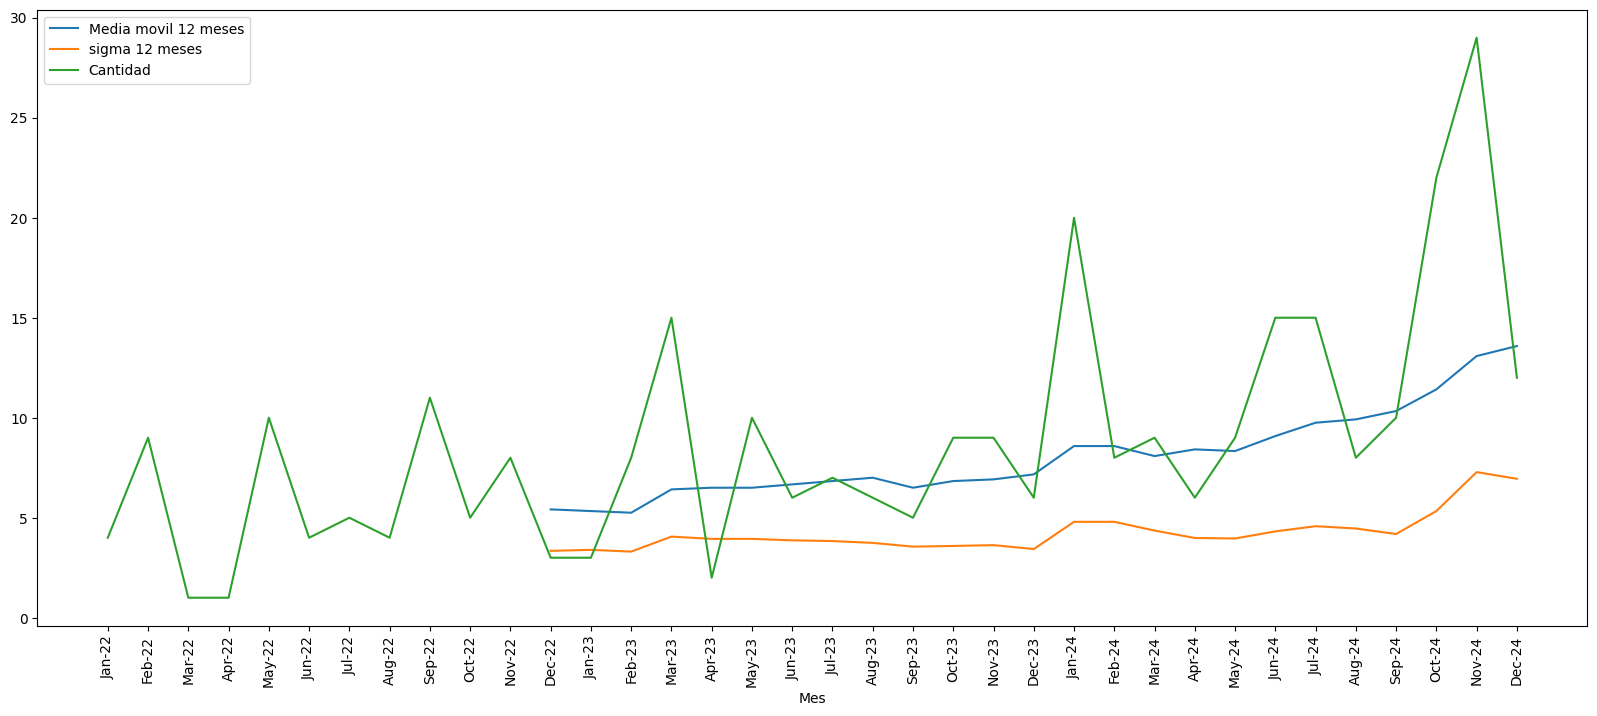

In [238]:
serietiempo = base_analisis['Cantidad']
type(serietiempo)
plt.figure(figsize=(20,8))
serietiempo.rolling(12).mean().plot(label= 'Media movil 12 meses')
serietiempo.rolling(12).std().plot(label= 'sigma 12 meses')
serietiempo.plot()
plt.xticks(rotation=90)  # Rotar los meses para que sean legibles
plt.xticks(ticks=range(len(base_analisis.index)), labels=base_analisis.index) 

plt.legend()


In [ ]:
#prueba de dickey-fuller aumentada

In [239]:
from statsmodels.tsa.stattools import adfuller

In [240]:
resultado = adfuller(base_analisis['Cantidad'])

resultado


(np.float64(2.1985982273212157),
 np.float64(0.9988813496541836),
 9,
 26,
 {'1%': np.float64(-3.7112123008648155),
  '5%': np.float64(-2.981246804733728),
  '10%': np.float64(-2.6300945562130176)},
 np.float64(151.70997901398516))

In [241]:
#diferenciacion
base_analisis['Primera diferencia'] = base_analisis['Cantidad'] - base_analisis['Cantidad'].shift(1)

<Axes: xlabel='Mes'>

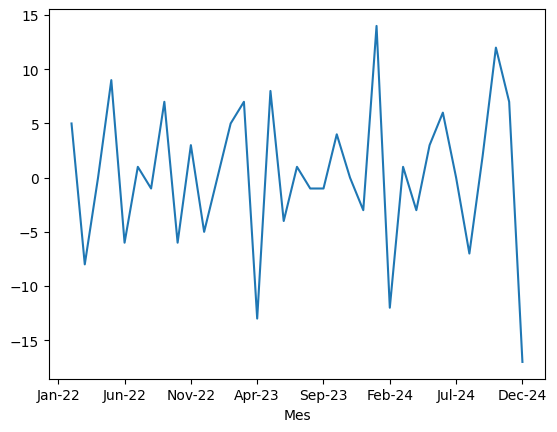

In [242]:
base_analisis['Primera diferencia'].plot()

In [243]:
adfuller(base_analisis['Primera diferencia'].dropna())

(np.float64(-3.883134228895271),
 np.float64(0.0021625362623537083),
 8,
 26,
 {'1%': np.float64(-3.7112123008648155),
  '5%': np.float64(-2.981246804733728),
  '10%': np.float64(-2.6300945562130176)},
 np.float64(152.59213075192383))

In [244]:
base_analisis['Segunda diferencia'] = base_analisis['Primera diferencia'] - base_analisis['Primera diferencia'].shift(1)

<Axes: xlabel='Mes'>

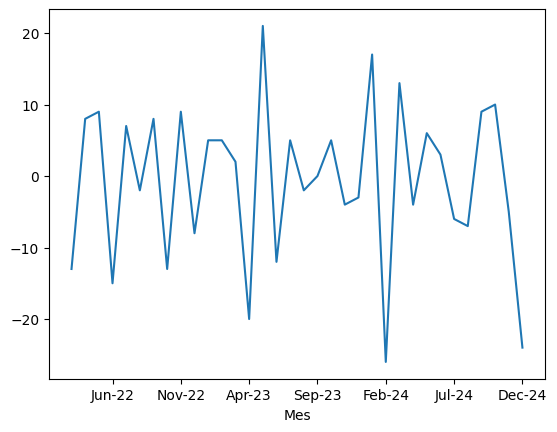

In [245]:
base_analisis['Segunda diferencia'].plot()

In [246]:
adfuller(base_analisis['Segunda diferencia'].dropna())

(np.float64(-3.2544893662783165),
 np.float64(0.017039476234092063),
 10,
 23,
 {'1%': np.float64(-3.7529275211638033),
  '5%': np.float64(-2.998499866852963),
  '10%': np.float64(-2.6389669754253307)},
 np.float64(149.11548388759118))

In [251]:
#diferencia con estacionalidad
base_analisis['Diferencia Estacionalidad'] = base_analisis['Cantidad'] - base_analisis['Cantidad'].shift(12)

<Axes: xlabel='Mes'>

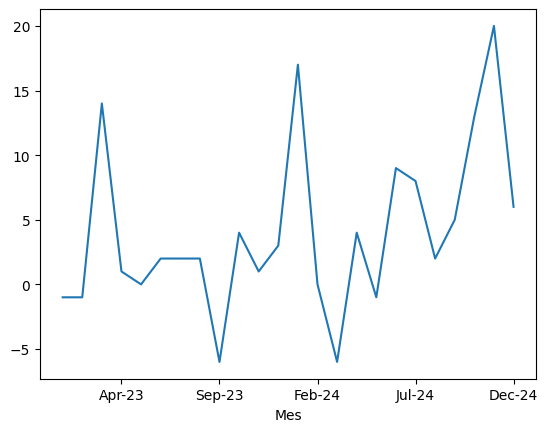

In [252]:
base_analisis['Diferencia Estacionalidad'].plot()

In [253]:
adfuller(base_analisis['Diferencia Estacionalidad'].dropna())

(np.float64(3.4292724399958705),
 1.0,
 9,
 14,
 {'1%': np.float64(-4.01203360058309),
  '5%': np.float64(-3.1041838775510207),
  '10%': np.float64(-2.6909873469387753)},
 np.float64(64.23418727968152))

In [254]:
base_analisis['Primera Diferencia Estacionalidad'] = base_analisis['Primera diferencia'] - base_analisis['Primera diferencia'].shift(2)

<Axes: xlabel='Mes'>

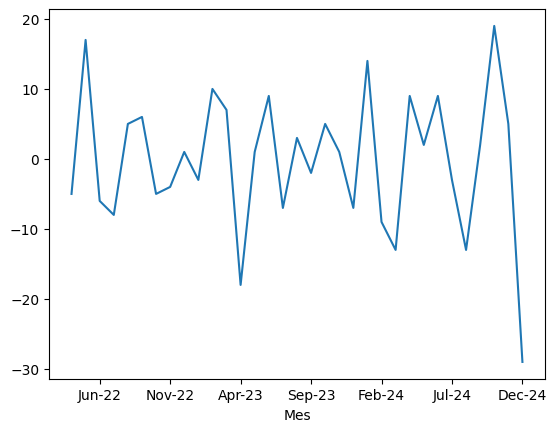

In [255]:
base_analisis['Primera Diferencia Estacionalidad'].plot()

In [256]:
adfuller(base_analisis['Primera Diferencia Estacionalidad'].dropna())

(np.float64(-3.3777435073033195),
 np.float64(0.011741401292854095),
 10,
 22,
 {'1%': np.float64(-3.769732625845229),
  '5%': np.float64(-3.005425537190083),
  '10%': np.float64(-2.6425009917355373)},
 np.float64(140.17877382500032))

PARTIR LA BASE

<Axes: xlabel='Mes'>

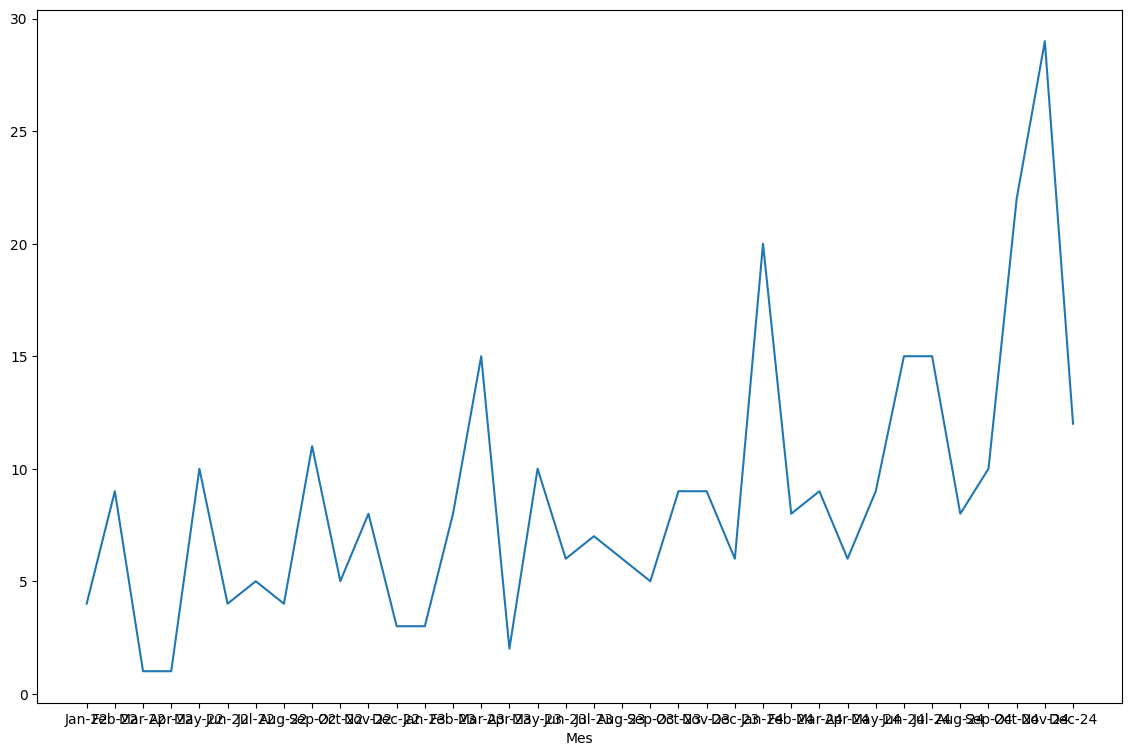

In [257]:
#partir la base en entrenamiento y prueba
plt.figure(figsize=(14,9))
plt.xticks(rotation=90)  # Rotar los meses para que sean legibles
plt.xticks(ticks=range(len(base_analisis.index)), labels=base_analisis.index) 
base_analisis['Cantidad'].plot()

In [290]:
BaseA = base_analisis[0:36]
BaseB = base_analisis[34:]
BaseA

,Cantidad,Primera diferencia,Segunda diferencia,Diferencia Estacionalidad,Primera Diferencia Estacionalidad
Mes,,,,,
Jan-22,4,NaN,NaN,NaN,NaN
Feb-22,9,5.0,NaN,NaN,NaN
Mar-22,1,-8.0,-13.0,NaN,NaN
Apr-22,1,0.0,8.0,NaN,-5.0
May-22,10,9.0,9.0,NaN,17.0
Jun-22,4,-6.0,-15.0,NaN,-6.0
Jul-22,5,1.0,7.0,NaN,-8.0
Aug-22,4,-1.0,-2.0,NaN,5.0
Sep-22,11,7.0,8.0,NaN,6.0


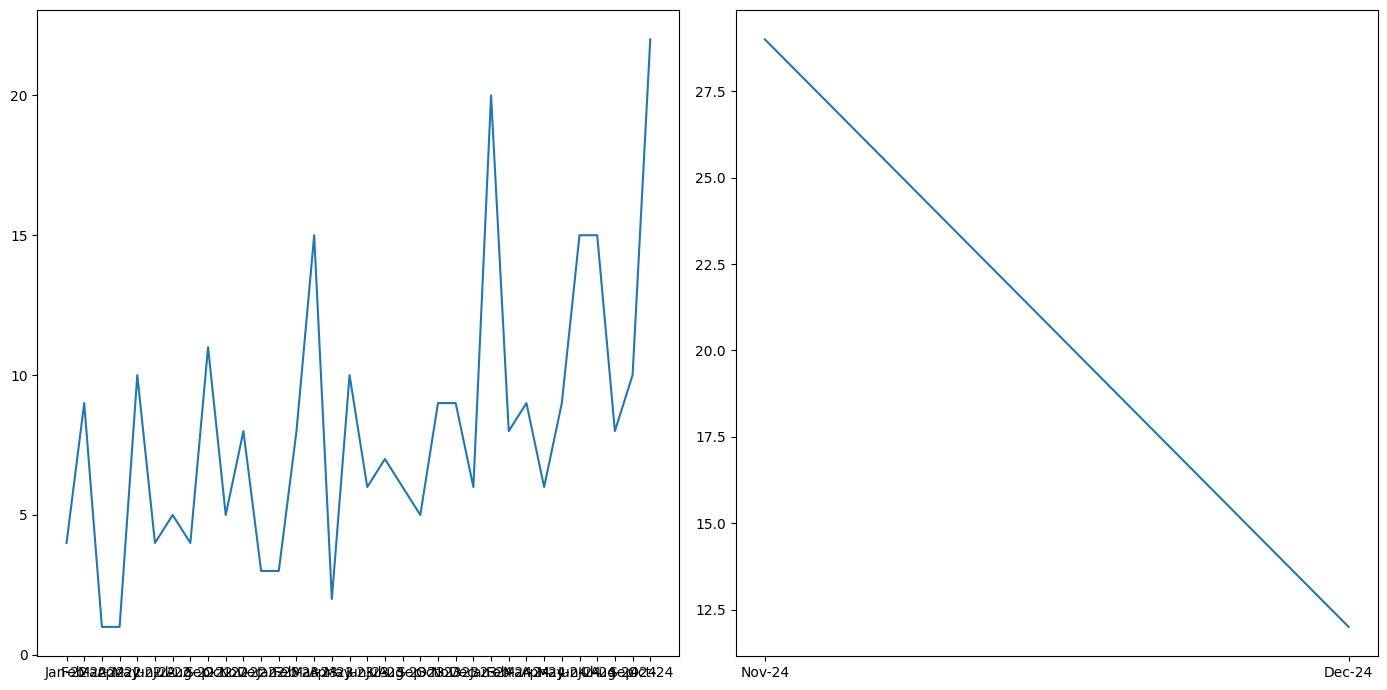

In [263]:

plt.figure(figsize=(14,7))

plt.subplot(1,2,1)
plt.plot(BaseA['Cantidad'],label='Ventas producto')


plt.subplot(1,2,2)
plt.plot(BaseB['Cantidad'],label='Ventas producto')


plt.tight_layout()



COMPONENTES ACF Y PACF

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

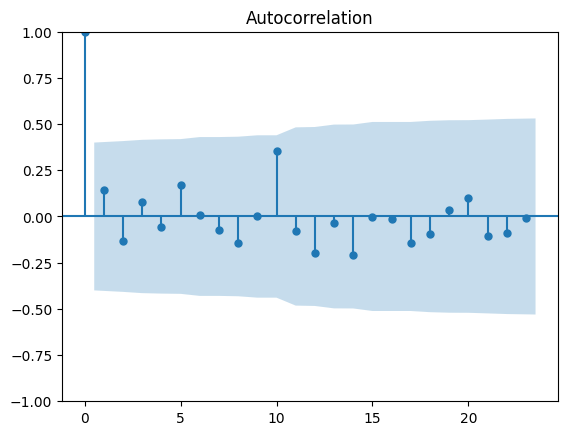

In [293]:
acf=plot_acf(BaseA['Diferencia Estacionalidad'].dropna(), lags=23)





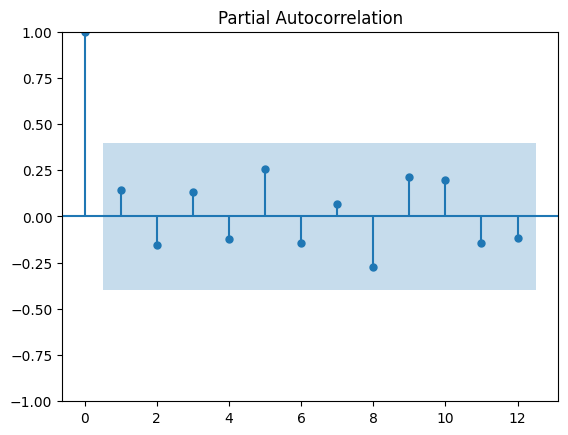

In [294]:
pacf=plot_pacf(BaseA['Diferencia Estacionalidad'].dropna(), lags=12)

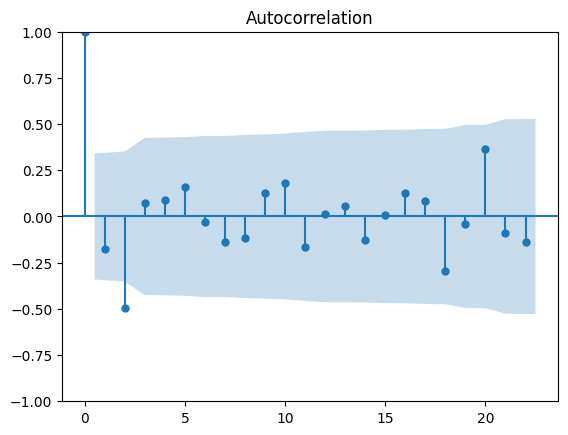

In [295]:
acf1=plot_acf(BaseA['Primera Diferencia Estacionalidad'].dropna(), lags=22)


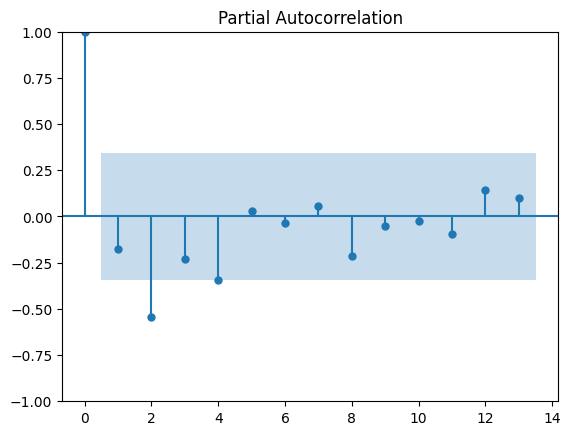

In [296]:
pacf1=plot_pacf(BaseA['Primera Diferencia Estacionalidad'].dropna(), lags=13)


In [208]:
from statsmodels.tsa.arima_model import  ARIMA

In [297]:
modelo = sm.tsa.statespace.SARIMAX(BaseA['Cantidad'],order=(0,1,1),seasonal_order=(0,1,0,12))

/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/home/serw

In [298]:
resultados = modelo.fit()

In [299]:
print(resultados.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Cantidad   No. Observations:                   36
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                 -76.888
Date:                             Tue, 11 Feb 2025   AIC                            157.777
Time:                                     22:25:27   BIC                            160.048
Sample:                                          0   HQIC                           158.348
                                              - 36                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8148      0.192     -4.241      0.000      -1.191      -0.438
sigma2        44.7304     1

DatetimeIndex(['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Mes', freq=None)


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/tmp/ipykernel_3641/3176792882.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_futuras = pd.date_range(start=BaseA.index[-1] + pd.DateOffset(months=1),


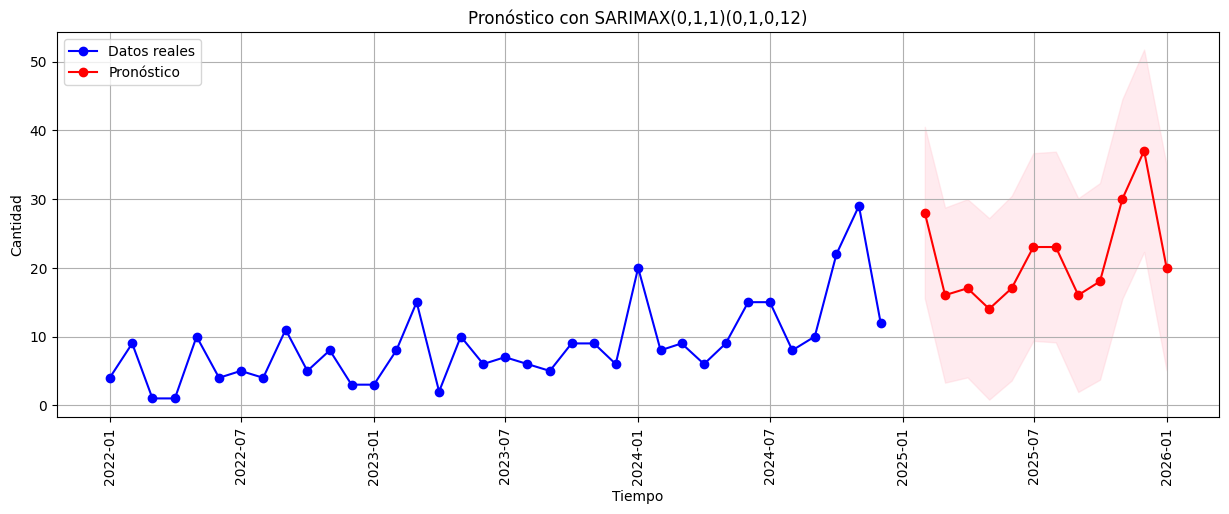

        Fecha  Pronóstico  Límite Inferior  Límite Superior
0  2025-01-31   28.021778        15.537458        40.506099
1  2025-02-28   16.021778         3.296699        28.746858
2  2025-03-31   17.021778         4.060411        29.983145
3  2025-04-30   14.021778         0.828355        27.215202
4  2025-05-31   17.021778         3.600310        30.443247
5  2025-06-30   23.021778         9.376076        36.667481
6  2025-07-31   23.021778         9.155467        36.888090
7  2025-08-31   16.021778         1.938314        30.105243
8  2025-09-30   18.021778         3.724458        32.319099
9  2025-10-31   30.021778        15.513754        44.529802
10 2025-11-30   37.021778        22.306067        51.737489
11 2025-12-31   20.021778         5.101271        34.942286


In [313]:
print(BaseA.index)


# 1️⃣ Crear el modelo SARIMAX
modelo_final = sm.tsa.statespace.SARIMAX(BaseA['Cantidad'],
                                         order=(0,1,1), 
                                         seasonal_order=(0,1,0,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

resultado = modelo_final.fit()

# 2️⃣ Hacer predicciones para los próximos 12 meses
periodos_prediccion = 12
predicciones = resultado.get_forecast(steps=periodos_prediccion)
intervalo_confianza = predicciones.conf_int()

# 3️⃣ Generar las fechas futuras para el eje X
BaseA.index = pd.to_datetime(BaseA.index, format='%b-%y')

if pd.isnull(BaseA.index[-1]):
    print("Error: Última fecha en BaseA no es válida")
else:
    fechas_futuras = pd.date_range(start=BaseA.index[-1] + pd.DateOffset(months=1), 
                                   periods=periodos_prediccion, freq='M')

# 4️⃣ Graficar los resultados
plt.figure(figsize=(15,5))
plt.plot(BaseA.index, BaseA['Cantidad'], label='Datos reales', color='blue', marker='o')
plt.plot(fechas_futuras, predicciones.predicted_mean, label='Pronóstico', color='red', marker='o')

# 5️⃣ Agregar etiquetas de valores en los puntos de pronóstico
# Asegurar que predicciones tengan las fechas correctas
predicciones_df = pd.DataFrame({'Prediccion': predicciones.predicted_mean}, index=fechas_futuras)

for i, (fecha, txt) in enumerate(predicciones_df.itertuples()):
    plt.annotate(f"{txt:.1f}", (fecha, txt), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='red')


# 6️⃣ Agregar banda de intervalo de confianza
plt.fill_between(fechas_futuras, 
                 intervalo_confianza.iloc[:, 0], 
                 intervalo_confianza.iloc[:, 1], 
                 color='pink', alpha=0.3)

# 7️⃣ Personalizar la visualización
plt.xticks(rotation=90)  # Rotar etiquetas del eje X
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.title('Pronóstico con SARIMAX(0,1,1)(0,1,0,12)')
plt.legend()
plt.grid()

# 8️⃣ Mostrar la gráfica
plt.show()

tabla_pronostico = pd.DataFrame({
    'Fecha': fechas_futuras,  # Fechas futuras
    'Pronóstico': predicciones.predicted_mean.values,  # Valores pronosticados
    'Límite Inferior': intervalo_confianza.iloc[:, 0].values,  # Intervalo inferior
    'Límite Superior': intervalo_confianza.iloc[:, 1].values   # Intervalo superior
})

# Mostrar la tabla en pantalla
print(tabla_pronostico)

# Opcional: Guardar la tabla en un archivo CSV
tabla_pronostico.to_csv('pro', index=False)
